#Step by step process of analyzing data and finding the best predictor.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

xAPI-Edu-Data.csv



First lets import everything

In [2]:
import seaborn as sns
sns.set(style='white')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Reading the data and dropping place of birth due to similarity. Also looking at mean and std of the data.

In [3]:
df = pd.read_csv("../input/xAPI-Edu-Data.csv")
#print df.shape

df = df.drop('PlaceofBirth',1)
#print df.head(5)

print (df.describe())

       raisedhands  VisITedResources  AnnouncementsView  Discussion
count   480.000000        480.000000         480.000000  480.000000
mean     46.775000         54.797917          37.918750   43.283333
std      30.779223         33.080007          26.611244   27.637735
min       0.000000          0.000000           0.000000    1.000000
25%      15.750000         20.000000          14.000000   20.000000
50%      50.000000         65.000000          33.000000   39.000000
75%      75.000000         84.000000          58.000000   70.000000
max     100.000000         99.000000          98.000000   99.000000


Lets create count plots for better visualization of data. 

(480, 16)


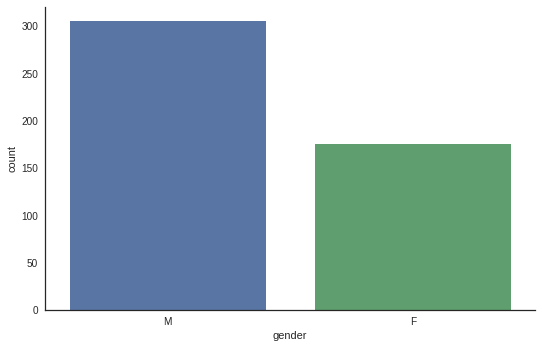

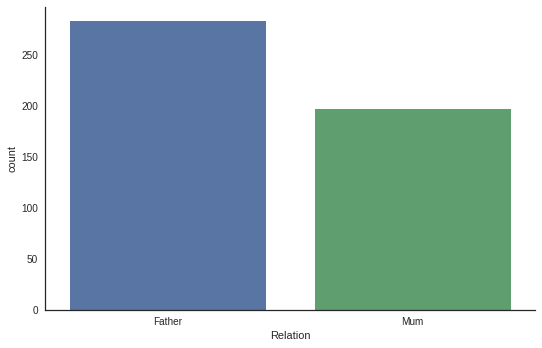

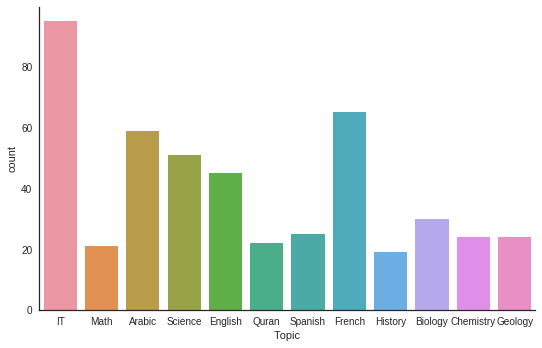

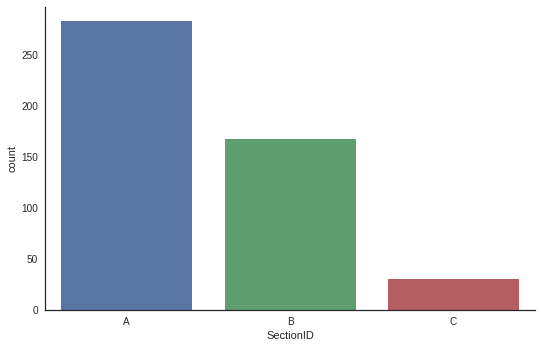

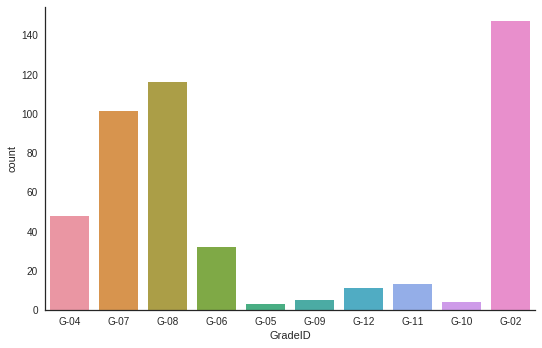

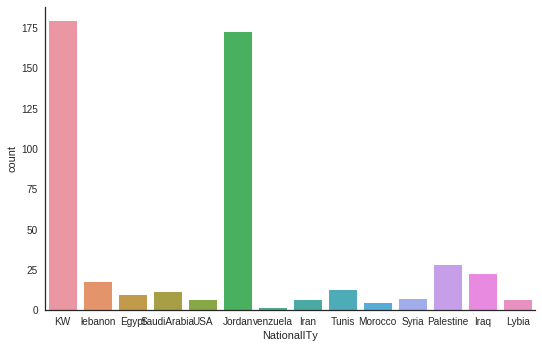

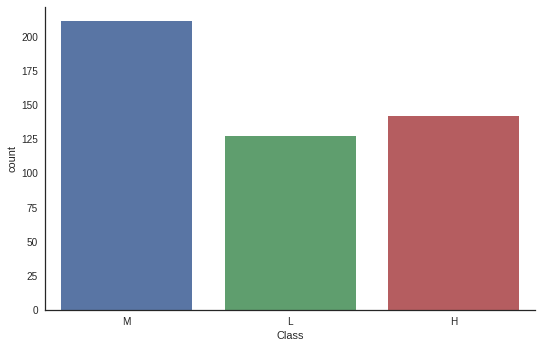

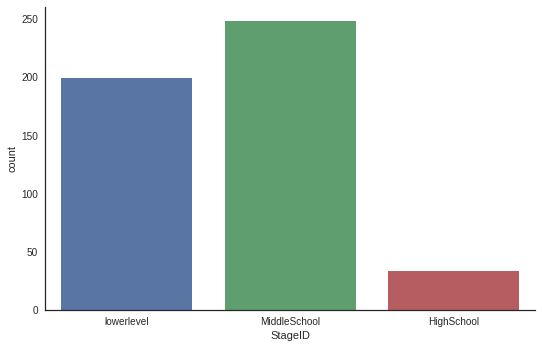

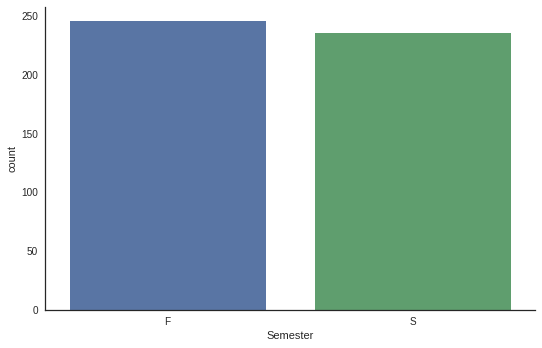

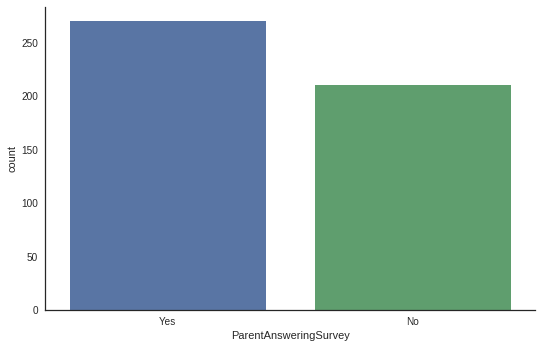

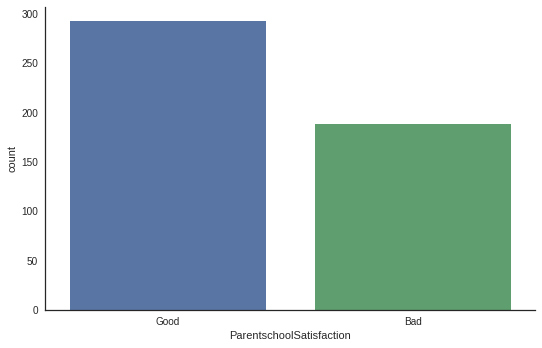

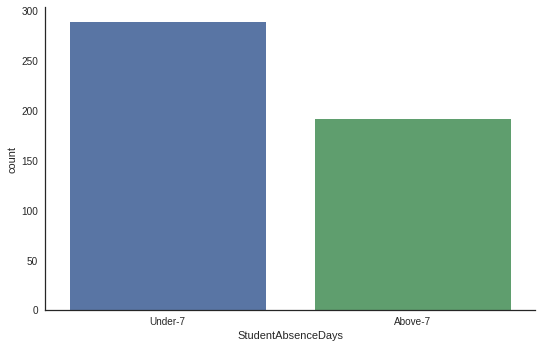

In [4]:
ls = ['gender','Relation','Topic','SectionID','GradeID','NationalITy','Class','StageID','Semester','ParentAnsweringSurvey','ParentschoolSatisfaction','StudentAbsenceDays']

for i in ls:
    g = sns.factorplot(i,data=df,kind='count',size=5,aspect=1.5)

print (df.shape)

We can observe disproportionate difference in peaks of attributes such as nationality, GradeID.

**Now let preprocess the data. First we do One hot Encoding to deal with categorical data .Then we split the data in train and test and also target and train. Finally we apply standard scaling to the data.**

In [5]:
#preprocessing

target = df.pop('Class')

X = pd.get_dummies(df)

le = LabelEncoder()
y = le.fit_transform(target)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
ss = StandardScaler()

X_train_std = ss.fit_transform(X_train)
X_test_std = ss.fit_transform(X_test)

Now due to one hot encoding we significantly increase the number of attributes. In order to reduce them I used Random forest classifier which shows the importances of attributes with respect to the target.

 1) VisITedResources               0.128494
 2) raisedhands                    0.115890
 3) AnnouncementsView              0.103508
 4) StudentAbsenceDays_Above-7     0.077869
 5) Discussion                     0.074674
 6) StudentAbsenceDays_Under-7     0.072676
 7) Relation_Mum                   0.031380
 8) Relation_Father                0.029454
 9) ParentAnsweringSurvey_No       0.026411
10) ParentAnsweringSurvey_Yes      0.025430
11) gender_F                       0.017401
12) ParentschoolSatisfaction_Bad   0.017162
13) gender_M                       0.016479
14) ParentschoolSatisfaction_Good  0.015377
15) NationalITy_KW                 0.015049
16) NationalITy_Jordan             0.013333
17) SectionID_A                    0.012821
18) SectionID_B                    0.012658
19) Topic_IT                       0.010894
20) StageID_lowerlevel             0.010393
21) StageID_MiddleSchool           0.010272
22) GradeID_G-02                   0.009433
23) Semester_S                  

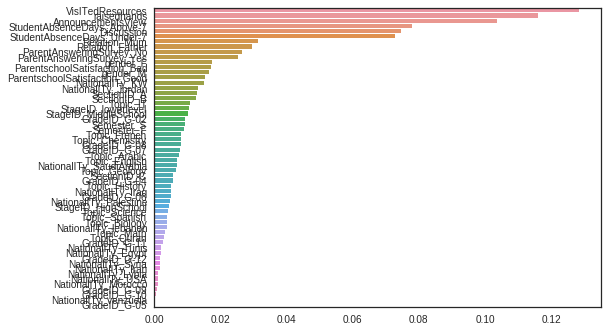

In [6]:
#dimensionality_reduction

feat_labels = X.columns[:58]
forest = RandomForestClassifier(n_estimators=1000,random_state=0,n_jobs=-1)
forest.fit(X_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
h = sns.barplot(importances[indices],feat_labels[indices])


As we observe first 6 attributes contribute significantly in the plot as compared to others. So we can safely remove others.

**Now we remove unnecessary dimensions or attributes.** 
Please someone tell me a more efficient way to do this.

In [7]:
#removing dimensions

X_train_new = X_train
X_test_new = X_test

ls = ['VisITedResources','raisedhands','AnnouncementsView','StudentAbsenceDays_Above-7','StudentAbsenceDays_Under-7','Discussion']

#Please someone tell me a more efficient way

for i in X_train.columns:
    if i in ls:
        pass
    else:
        X_train_new.drop(i , axis=1, inplace=True)
        
for i in X_test.columns:
    if i in ls:
        pass
    else:
        X_test_new.drop(i , axis=1, inplace=True)
        


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After this our data is ready to be spot checked by different algorithms.

In [8]:
#spot checking algorithms

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X_train_new, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.668673 (0.067942)
LASSO: -0.661985 (0.050468)
EN: -0.663328 (0.054669)
KNN: -0.672891 (0.140459)
CART: -1.090642 (0.264867)
SVR: -0.708123 (0.065446)


We can observe that the best result is shown by Lasso but this data is not yet scaled.
The scoring I have used is neg_mean_squared_error (0 means perfect)

Now lets standardize the data and plot a boxplot for better visual on the errors.

ScaledLR: -0.668673 (0.067942)
ScaledLASSO: -0.715119 (0.053704)
ScaledEN: -0.715119 (0.053704)
ScaledKNN: -0.700848 (0.164649)
ScaledCART: -1.092335 (0.225823)
ScaledSVR: -0.706310 (0.161411)


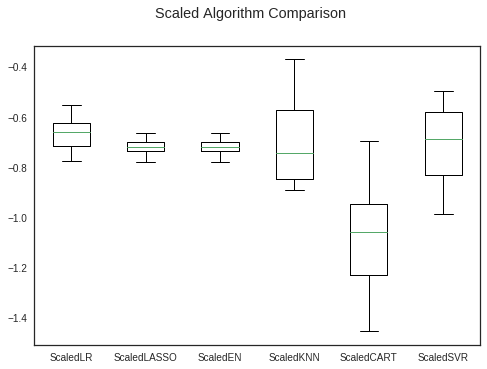

In [9]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X_train_new, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


We can see that although scaledLR does better, it has more variance. ScaledLasso and ScaledElasticNet have good score as well as less variance

**Thus we tune Lasso and see if we can further improve the result.**

In [10]:
#lasso algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
#the values chosen are done bby hit and trial during experimentations.
k_values = np.array([.1,.11,.12,.13,.14,.15,.16,.09,.08,.07,.06,.05,.04])
param_grid = dict(alpha=k_values)
model = Lasso()
kfold = KFold(n_splits=10, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.663016 using {'alpha': 0.040000000000000001}
-0.673846 (0.045413) with: {'alpha': 0.10000000000000001}
-0.675750 (0.045351) with: {'alpha': 0.11}
-0.677797 (0.045197) with: {'alpha': 0.12}
-0.680055 (0.045214) with: {'alpha': 0.13}
-0.682577 (0.045371) with: {'alpha': 0.14000000000000001}
-0.685450 (0.045753) with: {'alpha': 0.14999999999999999}
-0.688621 (0.046478) with: {'alpha': 0.16}
-0.671954 (0.045768) with: {'alpha': 0.089999999999999997}
-0.669985 (0.046523) with: {'alpha': 0.080000000000000002}
-0.668007 (0.047588) with: {'alpha': 0.070000000000000007}
-0.666307 (0.048784) with: {'alpha': 0.059999999999999998}
-0.664769 (0.050035) with: {'alpha': 0.050000000000000003}
-0.663016 (0.051018) with: {'alpha': 0.040000000000000001}


So the best value was obtained at alpha = 0.04 and other values are close as well

**Lets use ensembles to see if we can improve the accuracy and also plot the results.**

ScaledAB: -0.635280 (0.082547)
ScaledGBM: -0.674304 (0.109150)
ScaledRF: -0.639694 (0.121109)
ScaledET: -0.660388 (0.138161)


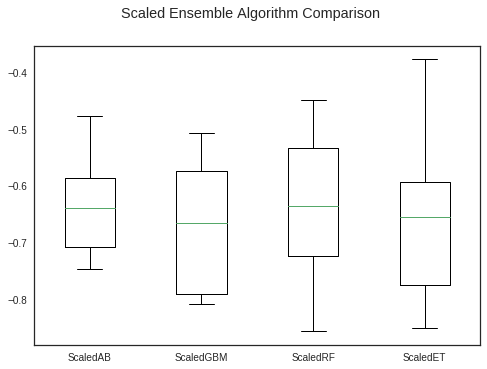

In [11]:
#using ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB',AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


Scaled AdaBoost seems to do better than every other with less variance.

**Now further tuning Adaboost**

In [12]:
# Tune scaled AdaboostRegressor
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = AdaBoostRegressor(random_state=7)
kfold = KFold(n_splits=10, random_state=7)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -0.614720 using {'n_estimators': 50}
-0.614720 (0.067768) with: {'n_estimators': 50}
-0.614720 (0.067768) with: {'n_estimators': 100}
-0.614720 (0.067768) with: {'n_estimators': 150}
-0.614720 (0.067768) with: {'n_estimators': 200}
-0.614720 (0.067768) with: {'n_estimators': 250}
-0.614720 (0.067768) with: {'n_estimators': 300}
-0.614720 (0.067768) with: {'n_estimators': 350}
-0.614720 (0.067768) with: {'n_estimators': 400}


Result does not vary at all with n estimators so we can use any.

**Finally lets prepare the model and see the final predictions**

In [13]:
# prepare the model by Adaboost
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = AdaBoostRegressor(random_state=7, n_estimators=400)
model.fit(rescaledX, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=400, random_state=7)

In [14]:
#prepare the model by LASSO
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_l = Lasso(random_state=7, alpha=0.04)
model_l.fit(rescaledX, y_train)

Lasso(alpha=0.04, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=7,
   selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
# transform the validation dataset by adaboost
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(y_test, predictions))

0.663250832334


In [16]:
# transform the validation dataset by lasso
rescaledValidationX = scaler.transform(X_test)
predictions = model_l.predict(rescaledValidationX)
print(mean_squared_error(y_test, predictions))

0.720384717894


#So we obtain somewhat 0.66 final error by adaboost and 0.72 by Lasso and during validation we got 0.61. This indicates little bit of overfitting in Adaboost but more in Lasso.